# HybridSN 高光谱图像分类

S. K. Roy, G. Krishna, S. R. Dubey, B. B. Chaudhuri HybridSN: Exploring 3-D–2-D CNN Feature Hierarchy for Hyperspectral Image Classification, IEEE GRSL 2020

这篇论文构建了一个 混合网络 解决高光谱图像分类问题，首先用 3D卷积，然后使用 2D卷积，代码相对简单，下面是代码的解析。

数据集已经下载到 src/data  文件夹之中，一共有三类数据{Indian-pines, PaviaU, Salinas}

引入基本函数库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

## 1. 定义 HybridSN 类

模型的网络结构为如下图所示：

![HybridSN结构图](./src/img/HybirdSN.png)

根据网络结构构建网络如下：

三维卷积部分：

conv1：（1, 30, 25, 25）， 8个 7x3x3 的卷积核 ==>（8, 24, 23, 23）

conv2：（8, 24, 23, 23）， 16个 5x3x3 的卷积核 ==>（16, 20, 21, 21）

conv3：（16, 20, 21, 21），32个 3x3x3 的卷积核 ==>（32, 18, 19, 19）

接下来要进行二维卷积，因此把前面的 32*18 reshape 一下，得到 （576, 19, 19）

二维卷积：（576, 19, 19） 64个 3x3 的卷积核，得到 （64, 17, 17）

接下来是一个 flatten 操作，变为 18496 维的向量，

接下来依次为256，128节点的全连接层，都使用比例为0.4的 Dropout，

最后输出为 16 个节点，是最终的分类类别数。

在基础的HybirdSN网络骨架上使用<font color='red'>注意力机制</font>，主要从<font color='red'>空间</font>和<font color='red'>通道</font>两个方面考虑

在3D卷积完成后，对输出的特征使用

    self.channel_attention_1 = ChannelAttention(576)
    self.spatial_attention_1 = SpatialAttention(kernel_size=7)

在2D卷积完成后，对输出特征使用

    self.channel_attention_1 = ChannelAttention(64)
    self.spatial_attention_1 = SpatialAttention(kernel_size=7)

下面是 HybridSN 类以及使用注意力机制的代码：

In [13]:
# 通道注意力
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)
# 空间注意力机制
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class HybridSN(nn.Module):
    def __init__(self, num_classes, self_attention=False):
        super(HybridSN, self).__init__()
        # out = (width - kernel_size + 2*padding)/stride + 1
        # => padding = ( stride * (out-1) + kernel_size - width)
        # 这里因为 stride == 1 所有卷积计算得到的padding都为 0

        #默认不使用注意力机制
        self.self_attention = self_attention

        # 3D卷积块
        self.block_1_3D = nn.Sequential(
            nn.Conv3d(
                in_channels=1,
                out_channels=8,
                kernel_size=(7, 3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                in_channels=8,
                out_channels=16,
                kernel_size=(5, 3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                in_channels=16,
                out_channels=32,
                kernel_size=(3, 3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(inplace=True)
        )
        if self_attention:
            self.channel_attention_1 = ChannelAttention(576)
            self.spatial_attention_1 = SpatialAttention(kernel_size=7)
        # 2D卷积块
        self.block_2_2D = nn.Sequential(
            nn.Conv2d(
                in_channels=576,
                out_channels=64,
                kernel_size=(3, 3)
            ),
            nn.ReLU(inplace=True)
        )
        if self_attention:
            self.channel_attention_2 = ChannelAttention(64)
            self.spatial_attention_2 = SpatialAttention(kernel_size=7)

        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=18496,
                out_features=256
            ),
            nn.Dropout(p=0.4),
            nn.Linear(
                in_features=256,
                out_features=128
            ),
            nn.Dropout(p=0.4),
            nn.Linear(
                in_features=128,
                out_features=num_classes
            )
        )
    def forward(self, x):
        y = self.block_1_3D(x)
        y = y.view(-1, y.shape[1] * y.shape[2], y.shape[3], y.shape[4])
        if self.self_attention:
            y = self.channel_attention_1(y) * y
            y = self.spatial_attention_1(y) * y
        y = self.block_2_2D(y)
        if self.self_attention:
            y = self.channel_attention_2(y) * y
            y = self.spatial_attention_2(y) * y
        #y = torch.flatten(y.detach())
        y = y.view(y.size(0), -1)

        y = self.classifier(y)
        # y = nn.LogSoftmax(y)
        return y
        # 全连接层

if __name__ == '__main__':
    # 随机输入，测试网络结构是否通
    x = torch.randn(1, 1, 30, 25, 25)
    net = HybridSN(num_classes=16, self_attention=True)
    y = net(x)
    #print(y.shape)
    print(y)

tensor([[-0.0737, -0.0600,  0.0236,  0.0658,  0.0893, -0.0331,  0.0234,  0.0051,
         -0.0023,  0.0463, -0.0039, -0.0243, -0.0757, -0.0388,  0.0743,  0.0404]],
       grad_fn=<AddmmBackward>)


## 2. 创建数据集

首先对高光谱数据实施PCA降维；然后创建 keras 方便处理的数据格式；然后随机抽取 10% 数据做为训练集，剩余的做为测试集。

首先定义基本函数：

In [3]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

下面读取并创建数据集：

In [4]:
# 地物类别
class_num = 16
X = sio.loadmat('./src/data/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('./src/data/Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape)
print('before transpose: Xtest  shape: ', Xtest.shape)

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape)
print('after transpose: Xtest  shape: ', Xtest.shape)


""" Training dataset"""
class TrainDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=0)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
Data cube X shape:  (10249, 25, 25, 30)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 25, 25, 30)
Xtest  shape:  (9225, 25, 25, 30)
before transpose: Xtrain shape:  (1024, 25, 25, 30, 1)
before transpose: Xtest  shape:  (9225, 25, 25, 30, 1)
after transpose: Xtrain shape:  (1024, 1, 30, 25, 25)
after transpose: Xtest  shape:  (9225, 1, 30, 25, 25)


## 3. 开始训练

In [14]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = HybridSN(num_classes=16, self_attention=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 开始训练
total_loss = 0
net.train() #注意启用训练模式
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.6f]   [current loss: %.6f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

print('Finished Training')

[Epoch: 1]   [loss avg: 21.519802]   [current loss: 2.635784]
[Epoch: 2]   [loss avg: 20.829661]   [current loss: 2.385289]
[Epoch: 3]   [loss avg: 20.266439]   [current loss: 2.535036]
[Epoch: 4]   [loss avg: 19.899978]   [current loss: 2.263760]
[Epoch: 5]   [loss avg: 19.692733]   [current loss: 2.302357]
[Epoch: 6]   [loss avg: 19.472280]   [current loss: 2.326110]
[Epoch: 7]   [loss avg: 19.193463]   [current loss: 2.156186]
[Epoch: 8]   [loss avg: 18.898808]   [current loss: 2.235258]
[Epoch: 9]   [loss avg: 18.566899]   [current loss: 1.896223]
[Epoch: 10]   [loss avg: 18.184090]   [current loss: 1.799522]
[Epoch: 11]   [loss avg: 17.758273]   [current loss: 1.623863]
[Epoch: 12]   [loss avg: 17.307700]   [current loss: 1.481050]
[Epoch: 13]   [loss avg: 16.810242]   [current loss: 1.270782]
[Epoch: 14]   [loss avg: 16.264767]   [current loss: 1.086986]
[Epoch: 15]   [loss avg: 15.668746]   [current loss: 0.744355]
[Epoch: 16]   [loss avg: 15.057714]   [current loss: 0.714396]
[

## 4. 模型测试

In [6]:
count = 0
# 模型测试
net.eval()  #注意启用测试模式
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     1.0000    0.8293    0.9067        41
         1.0     0.9894    0.9463    0.9674      1285
         2.0     0.9946    0.9906    0.9926       747
         3.0     0.9952    0.9812    0.9882       213
         4.0     0.9753    0.9977    0.9864       435
         5.0     0.9908    0.9863    0.9886       657
         6.0     1.0000    1.0000    1.0000        25
         7.0     0.9908    1.0000    0.9954       430
         8.0     0.9375    0.8333    0.8824        18
         9.0     0.9863    0.9897    0.9880       875
        10.0     0.9683    0.9950    0.9815      2210
        11.0     0.9720    0.9738    0.9729       534
        12.0     1.0000    0.9081    0.9518       185
        13.0     0.9913    0.9991    0.9952      1139
        14.0     0.9799    0.9827    0.9813       347
        15.0     0.8721    0.8929    0.8824        84

    accuracy                         0.9819      9225
   macro avg     0.9777   

在初始的模型上，如果多跑几次“模型测试代码块”，会发现每次分类的结果都不一样。

这是因为原始的代码没有注意到pytorch模型网络的<font color='red'>**训练模式**</font>和<font color='red'>**测试模式**</font>

即   <font color='red'>**net.train()**</font> 和 <font color='red'>**net.eval()**</font> (这里net是我们构建的HybirdSN)

由于网络的全连接层中使用了 <font color='red'>**nn.Dropout(p=0.4)**</font>

训练模式下是启用 Dropout和BN 层的，有些网络层的节点会随机失活。而<font color='red'>**原始代码在测试的时候没有启用测试模式**</font>，即使用的是训练模式，所以每次结果都是不一样的。

因此在训练和测试的时候分别启用相应模式就可以保证测试的结果是一样的了。

## 5. 备用函数
下面是用于计算各个类准确率，显示结果的备用函数，以供参考

In [7]:
from operator import truediv

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (test_loader, y_test, name):
    count = 0
    # 模型测试
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred =  outputs
            count = 1
        else:
            y_pred = np.concatenate( (y_pred, outputs) )

    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(y_test, y_pred, target_names=target_names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)

    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

检测结果写在文件里：

In [8]:
classification, confusion, oa, each_acc, aa, kappa = reports(test_loader, ytest, 'IP')
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

下面代码用于显示分类结果：

In [9]:
# load the original image
X = sio.loadmat('./src/data/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('./src/data/Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


D:\Anaconda3\envs\PyTorch\lib\site-packages\spectral\graphics\spypylab.py:27: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams['keymap.all_axes'] = ''
D:\Anaconda3\envs\PyTorch\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


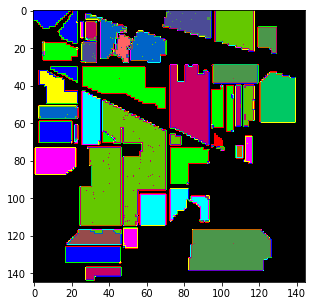

In [10]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))
